In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/startup-01.py
# start up settings for ipython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

plt.style.use('ggplot')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None 

In [2]:
import functools as fcts

# Tender sale as quality criteria
~20% of the tenders are deserted for various reasons, e.g., no offers. This means ~3000 tenders and ~7000 tender products are not sold. However, what happens to the deserted tenders? Investigation shows that public organizations actually can republish the same tender. As such, $\textit{tender traces}$ can occur where each item of the tender trace is an individual tender. Some trace actually ends with a tender that is sold. 
For example: (example where tender trace ends with a sold tender, explain that the company who bid could not have been created in 18 days)

## Research questions
- What characteristics do traces that end with sold state?
- Does the $\textit{persistence}$ of the related public organizations relate in better sale rate in general?
- Are there external factors, e.g., product type, region, and complaint number, affect the outcome of tender traces?

## Experiment design
- Classification to classify these different types of traces
- Clustering

## Preprocessing
1. Remove columns with >90% null values or 0 variance
2. Remove tenders with 1 tender product
3. Get deserted tenders
4. Do not consider tenders related to hospital and health because of granularity issues, many times there are such big variances in product of the same product code that make it difficult to differentiate one tender product from other without looking into the contract.
5. For all the deserted tenders, find similar tenders by the tender name and organization.
6. Filter tender traces by validating the tender products and tender publication and close dates

In [3]:
# # get the dfs from 2016
# tender_df_list = list()
# tprod_df_list = list()

# for f in os.listdir('../../data/processed2016/'):
#     if 'small' in f or 'raw' in f:
#         continue
#     if 'tenderProduct' in f:
#         tprod_df_list.append(f)
#     else:
#         tender_df_list.append(f)
        
# tender_df_list = sorted(tender_df_list)
# tprod_df_list = sorted(tprod_df_list)

# print(tender_df_list)
# print(tprod_df_list)

# tender_df_list = [pd.read_csv(os.path.join('../../data/processed2016/', df)) for df in tender_df_list]
# tprod_df_list = [pd.read_csv(os.path.join('../../data/processed2016/', df)) for df in tprod_df_list]

In [4]:
# get the dfs from 2016
tender_df_list = list()
tprod_df_list = list()

for f in os.listdir('../../data/processed2016/small'):
    if 'tsmall' in f:
        tender_df_list.append(f)
    else:
        tprod_df_list.append(f)
        
tender_df_list = sorted(tender_df_list)
tprod_df_list = sorted(tprod_df_list)

print(tender_df_list)
print(tprod_df_list)

tender_df_list = [pd.read_csv(os.path.join('../../data/processed2016/small', df)) for df in tender_df_list]
tprod_df_list = [pd.read_csv(os.path.join('../../data/processed2016/small', df)) for df in tprod_df_list]

['tsmall01.csv', 'tsmall02.csv', 'tsmall03.csv', 'tsmall04.csv', 'tsmall05.csv', 'tsmall06.csv', 'tsmall07.csv', 'tsmall08.csv', 'tsmall09.csv', 'tsmall10.csv', 'tsmall11.csv', 'tsmall12.csv']
['tsprod01.csv', 'tsprod02.csv', 'tsprod03.csv', 'tsprod04.csv', 'tsprod05.csv', 'tsprod06.csv', 'tsprod07.csv', 'tsprod08.csv', 'tsprod09.csv', 'tsprod10.csv', 'tsprod11.csv', 'tsprod12.csv']


In [5]:
for df in tender_df_list:
    df.FechasFechaPublicacion = pd.to_datetime(df.FechasFechaPublicacion)
    df.sort_values('FechasFechaPublicacion', ascending=True, inplace=True)

## Getting the deserted tender traces of length > 1

### Get deserted tenders

In [6]:
def get_deserted(tender_df):
    tdesert_df = tender_df[
        (tender_df['Estado'].str.lower().str.startswith('desier'))
    ]
    return tdesert_df

desert_df_list = list()
for tender_df in tender_df_list:
    desert_df = get_deserted(tender_df)
    desert_df_list.append(desert_df)

In [7]:
# def get_deserted(tender_df, tprod_df):
#     tdesert_df = tender_df[
#         (tender_df['Estado'].str.lower().str.startswith('desier'))
#     ]
#     tdesert_tids = tdesert_df['CodigoExterno'].values
#     tdprod_df = tprod_df[(tprod_df['CodigoExterno'].isin(tdesert_tids))]
#     desert_df = tdprod_df.merge(tdesert_df, on='CodigoExterno')
#     return desert_df

# desert_df_list = list()
# for tender_df, tprod_df in zip(tender_df_list, tprod_df_list):
#     desert_df = get_deserted(tender_df, tprod_df)
#     desert_df_list.append(desert_df)

In [8]:
def get_small_desert(tdesert_df):
    # the following organizations have low quality description in their tenders, basically they use the same tender name 
    # for the majority of their tenders
    excl_org_code = [7326, 87901]
    # some examples that did not make sense and therefore excluded
    excl_tid = ['3928-78-L116', '3928-82-L116', '3477-236-L116', '3477-241-L116',
               '2409-878-L116', '2409-910-L116']

    deserted = tdesert_df[
        ~(tdesert_df['CompradorCodigoOrganismo'].isin(excl_org_code))&
        ~(tdesert_df['CompradorNombreOrganismo'].str.lower().str.startswith('hospital'))&
        ~(tdesert_df['CompradorNombreOrganismo'].str.lower().str.contains('salud'))&
        ~(tdesert_df['CodigoExterno'].isin(excl_tid))
    ][['CodigoExterno', 'Nombre', 'FechasFechaPublicacion', 'FechasFechaCierre', 'CompradorCodigoOrganismo']].sort_values('FechasFechaPublicacion')
    return deserted

def get_similar_tenders(tender_df, deserted):
    similar_df = pd.DataFrame()
    checked = list()
    for td in deserted.itertuples():
        # check if this tender has been checked already
        if [td.CompradorCodigoOrganismo, td.Nombre] in checked:
            continue
        checked.append([td.CompradorCodigoOrganismo, td.Nombre])
        # identify similar tenders
        similar = tender_df[
            (tender_df['CompradorCodigoOrganismo']==td.CompradorCodigoOrganismo)&
            (tender_df['Nombre']==td.Nombre)
        ].sort_values('FechasFechaPublicacion')[['Estado', 'FechasFechaPublicacion', 'FechasFechaCierre', 'Nombre',
                                                 'CompradorNombreOrganismo', 'CompradorCodigoOrganismo', 'AdjudicacionUrlActa', 'CodigoExterno']]
        if similar_df.empty:
            similar_df = similar
        else:
            similar_df = pd.concat([similar_df, similar], axis=0)  
    return similar_df

deserted_small_df_list = list()
for df in desert_df_list:
    deserted = get_small_desert(df)
    deserted_small_df_list.append(deserted)
    
similar_df_list = list()
for tender_df, deserted_df in zip(tender_df_list, deserted_small_df_list):
    similar_df = get_similar_tenders(tender_df, deserted_df)
    similar_df_list.append(similar_df)

### Consider only traces with length > 1 and ensure validity

In [9]:
def get_trace_rows(similar_df):
    trace_spec = similar_df.groupby('Nombre').size()
#     print('Total deserted: {}\nTotal traces > 1: {}'.format(trace_spec[trace_spec == 1].shape, 
#                                                             trace_spec[trace_spec > 1].shape))
    trace_spec = trace_spec[trace_spec > 1].index.values
    trace_row_df = similar_df[(similar_df['Nombre'].isin(trace_spec))]
    return trace_row_df

trace_row_df_list = list()
for similar_df in similar_df_list:
    trace_row_df = get_trace_rows(similar_df)
    trace_row_df_list.append(trace_row_df)

In [10]:
def valid_dates(group, tids):
    # check dates
    last = None
    for tid in tids:
        if last is None:
            last = group[(group['CodigoExterno']==tid)][['FechasFechaPublicacion', 'FechasFechaCierre']].values[0]
        else:
            # check date
            now = group[(group['CodigoExterno']==tid)][['FechasFechaPublicacion', 'FechasFechaCierre']].values[0]
            if pd.to_datetime(now[0]) < pd.to_datetime(last[1]):
                # the publication date is smaller than the close date of the last tender
                return False
            last = now
    return True

def valid_tprods(tprod_df, tids):
    prod_dict = dict()
    for tid in tids:
        tprods = tprod_df[(tprod_df['CodigoExterno']==tid)]['CodigoProducto'].values
        tprods.sort()
        prod_dict[tid] = tprods
    # zip them
    for item_tuple in zip(*list(prod_dict.values())):
        if len(set(item_tuple)) > 1:
            return False
    return True

In [11]:
def filter_trace_row(trace_row_df, tprod_df):
    non_comply = list()
    for name, group in trace_row_df.groupby('Nombre'):
        tids = group['CodigoExterno'].values
        # check dates
        if not valid_dates(group, tids):
            non_comply.append(tids)
            continue
        # check products
        if not valid_tprods(tprod_df, tids):
            non_comply.append(tids)
            continue
    if len(non_comply) > 0:
        non_comply = fcts.reduce(lambda x, y: np.concatenate((x, y)), non_comply)
        trace_row_df = trace_row_df[~(trace_row_df['CodigoExterno'].isin(non_comply))]
    return trace_row_df

aux = list()
for df, tprod_df in zip(trace_row_df_list, tprod_df_list):
    trace_row_df = filter_trace_row(df, tprod_df)
    aux.append(trace_row_df)
    
trace_row_df_list = aux

In [12]:
# def filter_trace_row(trace_row_df):
#     non_comply = list()
#     for name, group in trace_row_df.groupby('Nombre'):
#         tids = group['CodigoExterno'].values
#         # check dates
#         if not valid_dates(group, tids):
#             non_comply.append(tids)
#             continue
#         # check products
#         if not valid_tprods(group, tids):
#             non_comply.append(tids)
#             continue
#     if len(non_comply) > 0:
#         non_comply = fcts.reduce(lambda x, y: np.concatenate((x, y)), non_comply)
#         trace_row_df = trace_row_df[~(trace_row_df['CodigoExterno'].isin(non_comply))]
#     return trace_row_df

# aux = list()
# for df in trace_row_df_list:
#     trace_row_df = filter_trace_row(df)
#     aux.append(trace_row_df)
    
# trace_row_df_list = aux

### Distribution across regions

22/362 has trace length > 1
24/381 has trace length > 1
18/386 has trace length > 1
39/538 has trace length > 1
36/488 has trace length > 1
44/507 has trace length > 1
26/411 has trace length > 1
31/485 has trace length > 1
17/417 has trace length > 1
21/420 has trace length > 1
33/474 has trace length > 1
17/319 has trace length > 1


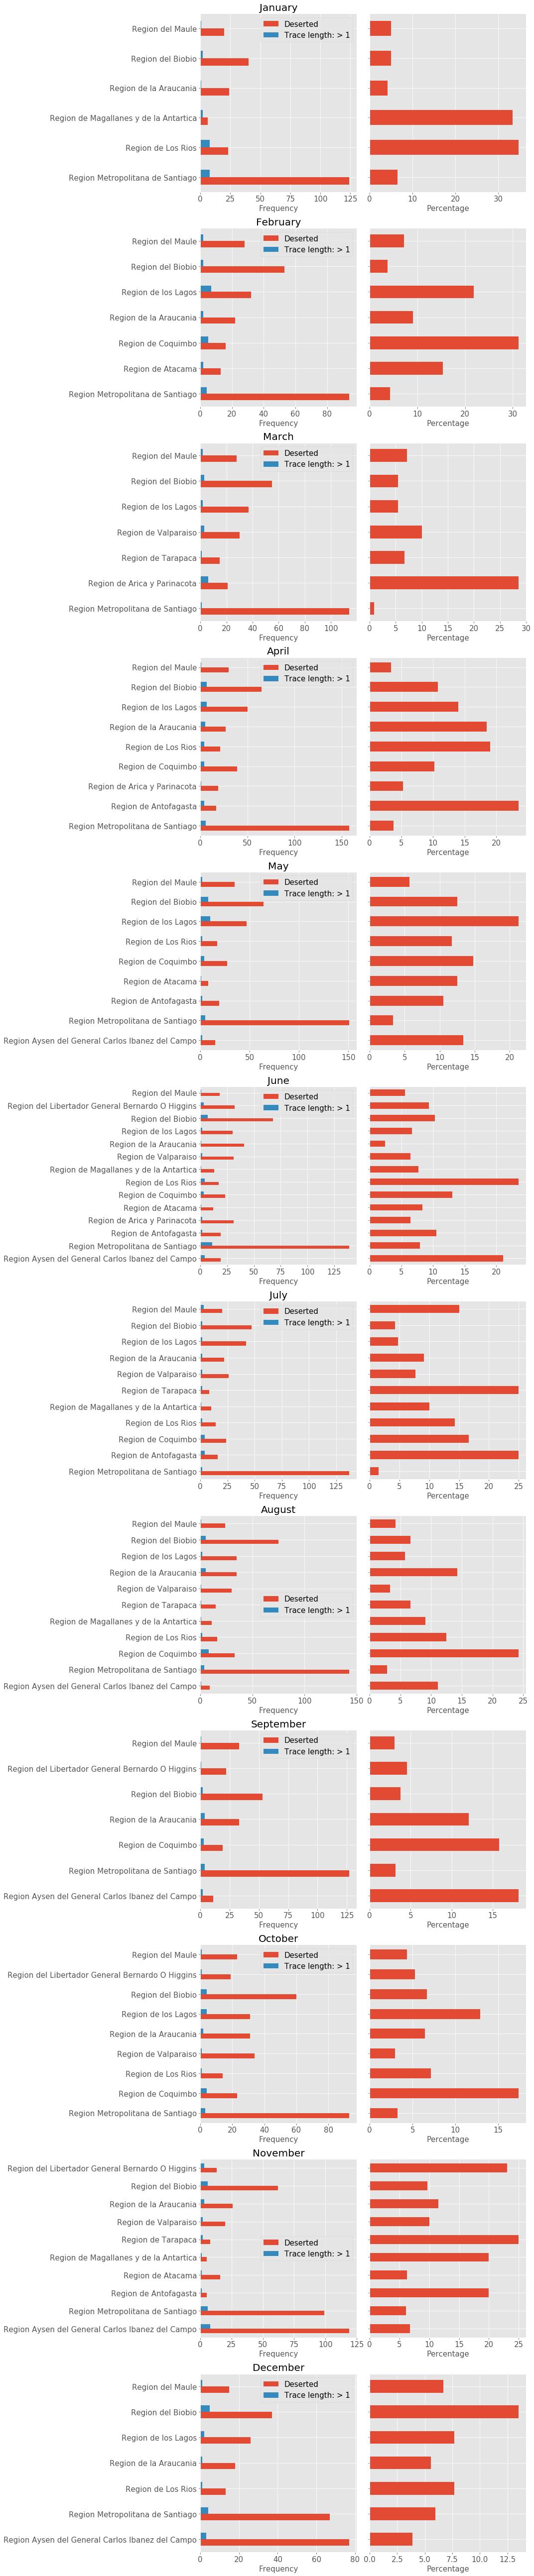

In [13]:
import calendar

def plot_trace_dist(tender_df, deserted, trace_row_df, rowid, axes):
    grouped_before = tender_df[(tender_df['CodigoExterno'].isin(deserted['CodigoExterno'].values))].groupby('CompradorRegionUnidad').size()
    grouped_after = tender_df[(tender_df['CodigoExterno'].isin(trace_row_df['CodigoExterno']))&
                             (tender_df['Estado'].str.lower().str.startswith('desi'))].groupby('CompradorRegionUnidad').size()
    
    print('{}/{} has trace length > 1'.format(grouped_after.sum(), grouped_before.sum()))
    
    grouped_before = grouped_before.to_frame().reset_index()
    grouped_after = grouped_after.to_frame().reset_index()
    grouped = grouped_before.merge(grouped_after, on='CompradorRegionUnidad')
    grouped.columns = ['CompradorRegionUnidad', 'Deserted', 'Trace length: > 1']
    grouped['perc'] = grouped['Trace length: > 1'] / grouped['Deserted'] * 100
    grouped.sort_values('CompradorRegionUnidad', inplace=True, ascending=True)

    grouped[['CompradorRegionUnidad', 'Deserted', 'Trace length: > 1']].plot(kind='barh', ax=axes[rowid, 0]);
    axes[rowid, 0].set_yticklabels(grouped['CompradorRegionUnidad'])
    axes[rowid, 0].set_xlabel('Frequency')
    axes[rowid, 0].set_title('{}'.format(calendar.month_name[rowid+1]), fontsize=20);

    grouped[['CompradorRegionUnidad', 'perc']].plot(kind='barh', ax=axes[rowid, 1], legend=None);
    axes[rowid, 1].set_yticklabels([]);
    axes[rowid, 1].set_xlabel('Percentage');

rowid_list = range(12)
fig, axes = plt.subplots(figsize=(15, 6 * 12), ncols=2, nrows=12)
for tender_df, deserted, trace_row_df, rowid in zip(tender_df_list, deserted_small_df_list, 
                                                    trace_row_df_list, rowid_list):
    plot_trace_dist(tender_df, deserted, trace_row_df, rowid, axes)

plt.tight_layout();

We can see that Region Biobio tend to be more persistent relatively as more of the deserted tenders in this region are republished. Next we would like to know how likely is a deserted tender going to revive.

### General observations

In [14]:
avg_revival_rate = list()
month = 1
for trace_row_df in trace_row_df_list:
    grouped_state = trace_row_df.groupby('Nombre').apply(lambda x: 'Adjudicada' in x['Estado'].values)
    revival_rate = (grouped_state.sum() / grouped_state.shape[0])
    print('Revival rate ({:02d}): {:.2f}% ({}/{})'.format(month, revival_rate, grouped_state.sum(), grouped_state.shape[0]))
    month += 1
    avg_revival_rate.append((revival_rate, grouped_state.shape[0]))

total_sale = fcts.reduce(lambda x, y: x + y[1], avg_revival_rate, 0)
avg_revival_rate = fcts.reduce(lambda x, y: x + y[0] * (y[1] / total_sale), avg_revival_rate, 0)
print('Weighted avg revival rate: {:.2f}'.format(avg_revival_rate))

Revival rate (01): 0.60% (9/15)
Revival rate (02): 0.74% (14/19)
Revival rate (03): 0.88% (14/16)
Revival rate (04): 0.77% (24/31)
Revival rate (05): 0.58% (15/26)
Revival rate (06): 0.60% (18/30)
Revival rate (07): 0.76% (16/21)
Revival rate (08): 0.75% (18/24)
Revival rate (09): 0.71% (10/14)
Revival rate (10): 0.60% (9/15)
Revival rate (11): 0.55% (12/22)
Revival rate (12): 0.79% (11/14)
Weighted avg revival rate: 0.69


This is quite incredible, 67% of the ones that republished the same tender gets sold.

### Distribution in terms of product category

In [15]:
grouped_cat = tprod_df[
    (tprod_df['CodigoExterno'].isin(trace_row_df['CodigoExterno'].values))
].groupby('Categoria').size().to_frame().reset_index()

grouped_cat.columns = ['Categoria', 'count']
grouped_cat.sort_values('count', inplace=True, ascending=False)
grouped_cat.reset_index(drop=True, inplace=True)

grouped_cat.head()

,Categoria,count
0,Instrumentos musicales juegos juguetes artesanias y materiales educativos / Juguetes y juegos / Juguetes,36
1,Articulos de fabricacion y produccion / Articulos de ferreteria / Tornillos,20
2,Servicios de transporte almacenaje y correo / Transporte de pasajeros / Transporte de pasajeros por carretera,14
3,Equipos y suministros de defensa orden publico proteccion y seguridad / Proteccion contra incendios / Equipos para combatir incendios,12
4,Articulos de fabricacion y produccion / Articulos de ferreteria / Espaciadores,12


## Divide to two classes

In [16]:
def merge_df(trace_row_df):
    grouped_state = trace_row_df.groupby('Nombre').apply(lambda x: int('Adjudicada' in x['Estado'].values))
    grouped_state = grouped_state.to_frame().reset_index()
    grouped_state.columns = ['Nombre', 'class_sold']

    merged = trace_row_df.merge(grouped_state, on='Nombre')
    merged[(merged['class_sold']==0)]

    return merged

merged_df_list = list()
for trace_row_df in trace_row_df_list:
    merged = merge_df(trace_row_df)
    merged_df_list.append(merged)

### Revived case
An example where a tender gets revived in a re-publication.

In [17]:
merged_all_df = pd.concat(merged_df_list, axis=0)

merged_all_df[
    (merged_all_df['CodigoExterno'].isin(['2401-442-L116', '2401-467-L116']))
]

,Estado,FechasFechaPublicacion,FechasFechaCierre,Nombre,CompradorNombreOrganismo,CompradorCodigoOrganismo,AdjudicacionUrlActa,CodigoExterno,class_sold
4,Desierta o art 3 o 9 Ley 19 886,2016-11-02 15:33:25.950,2016-11-08T12:01:00,MOCHILAS PROYECTO INFANCIA,ILUSTRE MUNICIPALIDAD DE RANCAGUA,87167,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=t27FwHY6GxhIEjFmTlRD6yyYduI7UlEBWC6N4Q0ABXo=,2401-442-L116,1
5,Adjudicada,2016-11-15 17:04:11.183,2016-11-22T12:00:00,MOCHILAS PROYECTO INFANCIA,ILUSTRE MUNICIPALIDAD DE RANCAGUA,87167,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=ckCgGyh5kukvjtTq6rUOy23XxwBsgCyz3x7T4cedS3k=,2401-467-L116,1


### Remains dead
An example where a tender remains deserted in the future re-publication.

In [18]:
merged_all_df[
    (merged_all_df['CodigoExterno'].isin(['1989-99-L116', '1989-104-CO16']))
]

,Estado,FechasFechaPublicacion,FechasFechaCierre,Nombre,CompradorNombreOrganismo,CompradorCodigoOrganismo,AdjudicacionUrlActa,CodigoExterno,class_sold
2,Desierta o art 3 o 9 Ley 19 886,2016-11-02 15:23:50.373,2016-11-10T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=HJfcGaPNPX9fLUtNwNIuJVnzatvdmhHFwZl9efRvz+U=,1989-99-L116,0
3,Desierta o art 3 o 9 Ley 19 886,2016-11-23 16:37:08.103,2016-12-01T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=Qn8nkbm19kyaC/lMqhdo9XBRJBMJ0G6q2k62Rth9e/I=,1989-104-CO16,0


## Constructing trace df with features

In [19]:
def compute_lapse(tname, df):
    trace = df[(df['Nombre']==tname)]
    last = None
    lapse_list = list()
    for tender in trace.itertuples():
        now = tender
        if last is not None:
            # compute lapse
            lapse_list.append(now.FechasFechaPublicacion - last.FechasFechaCierre)
        last = now
    return np.mean(lapse_list)

def compute_duration(tname, df):
    return df.loc[(df['Nombre']==tname), 'tender_duration'].mean()

def cmp_desc_chg(tname, df):
    trace = df[(df['Nombre']==tname)]
    last = None
    change_list = list()
    for tender in trace.itertuples():
        now = tender
        if last is not None:
            # compute lapse
            change_list.append(now.desc_len - last.desc_len)
        last = now
    return np.mean(change_list)

def cmp_trace_len(tname, df):
    return df[(df['Nombre']==tname)].shape[0]

In [20]:
tall_df_list = list()

for tender_df, tprod_df in zip(tender_df_list, tprod_df_list):
    tall_df = tprod_df.merge(tender_df, on='CodigoExterno')
    tall_df_list.append(tall_df)

In [21]:
def compute_tender_duration(df):
    df['FechasFechaPublicacion'] = pd.to_datetime(df.loc[:,'FechasFechaPublicacion'])
    df['FechasFechaCierre'] = pd.to_datetime(df.loc[:,'FechasFechaCierre'])
    df['tender_duration'] = df['FechasFechaCierre'] - df['FechasFechaPublicacion']

In [22]:
def get_avg_df(tall_df):
    # product code, region, average number of words in description, item quantity, reclamos, 
    aux = tall_df[['CodigoProducto', 'CompradorRegionUnidad', 'Descripcion_x', 
                   'ItemsCantidad', 'CantidadReclamos', 'CodigoExterno']]
    aux['desc_len'] = aux['Descripcion_x'].astype(str).apply(lambda x: len(x))
    aux['desc_len'] = aux['desc_len'].fillna(0)
#    print(aux['desc_len'].unique())
    frame = aux.groupby('CodigoExterno').agg({'desc_len': 'mean'})
    frame = frame.reset_index()
    aux = aux.drop('desc_len', axis=1)
    aux = aux.merge(frame, on='CodigoExterno')
    aux.drop_duplicates('CodigoExterno', inplace=True)
    return aux

tall_avg_df_list = list()
for tall_df in tall_df_list:
    tall_avg_df = get_avg_df(tall_df)
    tall_avg_df_list.append(tall_avg_df)

In [23]:
def get_trace_df(merged, tall_avg_df):
    trace_df = merged[['Nombre', 'class_sold', 'CompradorCodigoOrganismo', 'CodigoExterno',
                      'FechasFechaPublicacion', 'FechasFechaCierre']]
    compute_tender_duration(trace_df)
    trace_df.loc[:,'lapse'] = trace_df.loc[:,'Nombre'].apply(lambda x: compute_lapse(x, trace_df))
    trace_df['avg_tduration'] = trace_df.loc[:,'Nombre'].apply(lambda x: compute_duration(x, trace_df))
    
    # trace_df = trace_df.merge(merged[['Nombre', 'CodigoExterno']], on='Nombre')
    trace_df = trace_df.merge(tall_avg_df, on='CodigoExterno')
    trace_df['name_len'] = trace_df['Nombre'].apply(len) 
    trace_df['avg_desc_chg'] = trace_df['Nombre'].apply(lambda x: cmp_desc_chg(x, trace_df))
    trace_df['trace_len'] = trace_df['Nombre'].apply(lambda x: cmp_trace_len(x, trace_df))
    trace_df = trace_df[[colname for colname in trace_df.columns if colname != 'CodigoExterno']]
    trace_df = trace_df[[colname for colname in trace_df.columns 
                         if not (colname == 'Descripcion_x' or colname == 'CodigoExterno' 
                                 or colname == 'Nombre' or colname == 'FechasFechaPublicacion' 
                                or colname == 'FechasFechaCierre' or colname == 'tender_duration' 
                                or colname == 'CodigoProducto') ]]
    # convert timedelta columns to hours
    trace_df['lapse'] = trace_df['lapse'].dt.components.hours
    trace_df['avg_tduration'] = trace_df['avg_tduration'].dt.components.hours
    
    return trace_df

trace_df_list = list()
for merged_df, tall_avg_df in zip(merged_df_list, tall_avg_df_list):
    trace_df = get_trace_df(merged_df, tall_avg_df)
    trace_df_list.append(trace_df)

In [24]:
trace_df = pd.concat(trace_df_list, axis=0)

### Convert to numerical

In [25]:
trace_df.columns

Index(['class_sold', 'CompradorCodigoOrganismo', 'lapse', 'avg_tduration',
       'CompradorRegionUnidad', 'ItemsCantidad', 'CantidadReclamos',
       'desc_len', 'name_len', 'avg_desc_chg', 'trace_len'],
      dtype='object')

In [26]:
from sklearn import preprocessing

# make the following columns to string so that they can be mapped to lower values for training
trace_df['CompradorCodigoOrganismo'] = trace_df['CompradorCodigoOrganismo'].astype(str)
# trace_df['CodigoProducto'] = trace_df['CodigoProducto'].astype(str)

le_dict = dict()
for col in trace_df.columns:
    if np.issubdtype(trace_df[col].dtype, np.number):
        continue
    le = preprocessing.LabelEncoder()
    # fit the labels
    _ = le.fit(trace_df[col])
    # transform the labels
    trace_df[col] = le.transform(trace_df[col])
    # save the labeler
    le_dict[col] = le

### Remove columns that have low variance

In [27]:
var_threshold = .01
for col in trace_df.columns:
    if trace_df[col].var() < var_threshold:
        print('Removing column: {}'.format(col))
        trace_df.drop(col, axis=1, inplace=True)

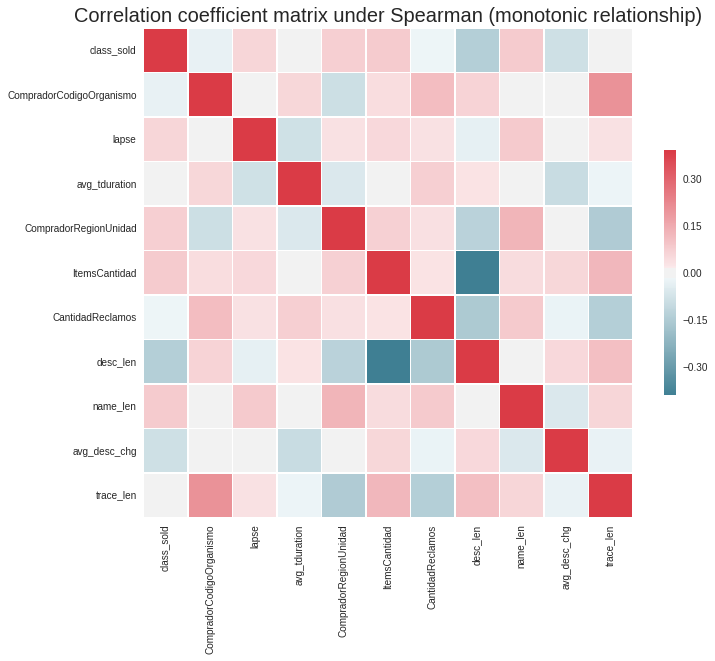

In [28]:
import seaborn as sns

corr = trace_df.corr('spearman')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
               square=True, linewidth=.5, cbar_kws={'shrink': .5})

_ = ax.set_title('Correlation coefficient matrix under Spearman (monotonic relationship)', fontsize=20)

## Evaluate with classifier on class_sold

In [29]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn.dummy import DummyClassifier

'''
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
'''
names = ["Dummy (Stratified)", "Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    DummyClassifier(strategy='stratified', random_state=0, constant=0),
    KNeighborsClassifier(3),
#    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

'\nnames = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",\n         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",\n         "Naive Bayes", "QDA"]\n'

### Distribution of class_sold

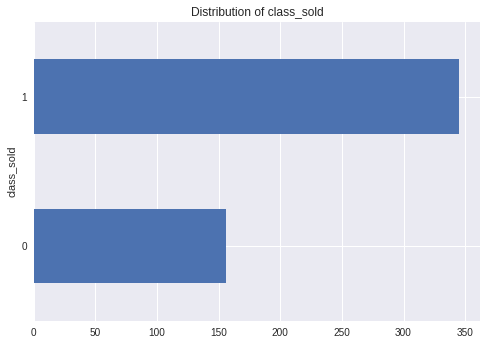

In [30]:
grouped = trace_df.groupby('class_sold').size()
ax = grouped.plot(kind='barh')
ax.set_title('Distribution of class_sold');

Given that the two classes are only slightly unbalanced, there's really no need to oversample, but let's try it anyway.

### Create train and test sets

In [31]:
dataset_y = trace_df['class_sold']
dataset_X = trace_df.drop('class_sold', axis=1)

train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, test_size=.4, random_state=123)

# there can be overlap between train and test sets where there are instances duplicated in both train and test
# for fairer test, remove those from test
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)
before = test.shape[0]

merged = pd.merge(test, train, how='outer', indicator=True)
# select only left_only, i.e., unique test set instances
test_no_dup = merged.loc[merged._merge=='left_only']
test_no_dup.drop('_merge', inplace=True, axis=1)
after = test_no_dup.shape[0]
print('Removed {} rows from test set with original: {}'.format(before - after, before))
print('Removed {:.2f}% of original'.format((before - after) / before * 100))

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# oversample train set
grouped = train.groupby('class_sold').size()
to_oversample = int(abs(grouped.diff()[1]))
print('Oversampling {} rows...'.format(to_oversample))
idx = np.random.choice(train.loc[train['class_sold'] == 0].index, size=to_oversample)
train_oversampled = pd.concat([train, train.iloc[idx]])

train_ds_list = [train, train_oversampled]
train_ds_namelist = ['Original', 'Oversampled']

test_ds_list = [test, test_no_dup]
test_ds_namelist = ['Original', 'No duplicates']

Removed 92 rows from test set with original: 201
Removed 45.77% of original
Oversampling 98 rows...


In [32]:
import multiprocessing
from multiprocessing import Queue
import math

In [33]:
# parallelize at the level of classifiers
def mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs):
    def worker(train_X, train_y, test_X, test_y, name_list, clf_list, out_q):
        '''
        The worker function, invoked in a process. 
        '''
        outdict = {}
        for name, clf in zip(name_list, clf_list):
            # train and test classifier
            # print('Training {}...'.format(name))
            clf.fit(train_X, train_y)
            # print('Testing {}...'.format(name))
            y_pred = clf.predict(test_X)
#            report = classification_report(y_pred=y_pred, y_true=test_y)
            scores = precision_recall_fscore_support(y_pred=y_pred, y_true=test_y)
            score_list = list(zip([name for _ in range(len(scores[0]))], clf.classes_,
                                 scores[0], scores[1], scores[2], scores[3]))
            # put report to dict
            outdict[name] = score_list
        # put to out_q
        out_q.put(outdict)
        
    # Each process wil get 'chunksize' clfs and a queue to put the outdict in
    out_q = Queue()
    chunksz = int(math.ceil(len(classifiers) / float(nprocs)))
    procs = []
    
    for i in range(nprocs):
        start = chunksz * i
        end = chunksz * (i + 1)
        p = multiprocessing.Process(
                target=worker,
                args=(train_X, train_y, test_X, test_y, 
                      names[start:end], classifiers[start:end], out_q))
        procs.append(p)
        p.start()
    
    # Collect all results into a single result dict
    resultdict = dict()
    for i in range(nprocs):
        outdict = out_q.get()
        resultdict.update(outdict)
    # turn resultdict to dataframe
    # print(list(resultdict.values()))
    values = fcts.reduce(lambda l, x: l + x, list(resultdict.values()))
    values = list(zip(*values))
    value_dict = {'clf': values[0], 'class': values[1],
                'precision': values[2], 'recall': values[3],
                'f1': values[4], 'support': values[5]}
    result_df = pd.DataFrame(value_dict)
        
    # wait for all worker processes to finish
    for p in procs: 
        p.join()
    
    return result_df

In [34]:
nprocs = multiprocessing.cpu_count()
# print(nprocs)

result_df = pd.DataFrame()
for train_ds_name, train_ds in zip(train_ds_namelist, train_ds_list):
    train_X = train_ds.drop('class_sold', axis=1)
    train_y = train_ds['class_sold']
    # print('Training on {} dataset'.format(train_ds_name))
    
    for test_ds_name, test_ds in zip(test_ds_namelist, test_ds_list):
        test_X = test_ds.drop('class_sold', axis=1)
        test_y = test_ds['class_sold']
        # los experimentos fueron realizados en otro computador, solamente importamos los resultados
        
        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)
        # columns about train and test set
        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]
        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]
        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]
        if result_df.empty:
            result_df = out_df
        else:
            result_df = pd.concat([result_df, out_df], axis=0)

'''
outdir = '.' + os.sep + 'out'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
result_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)
'''

# result_df = pd.read_csv('.' + os.sep + 'out' + os.sep + 'classificationResult.csv')

"\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

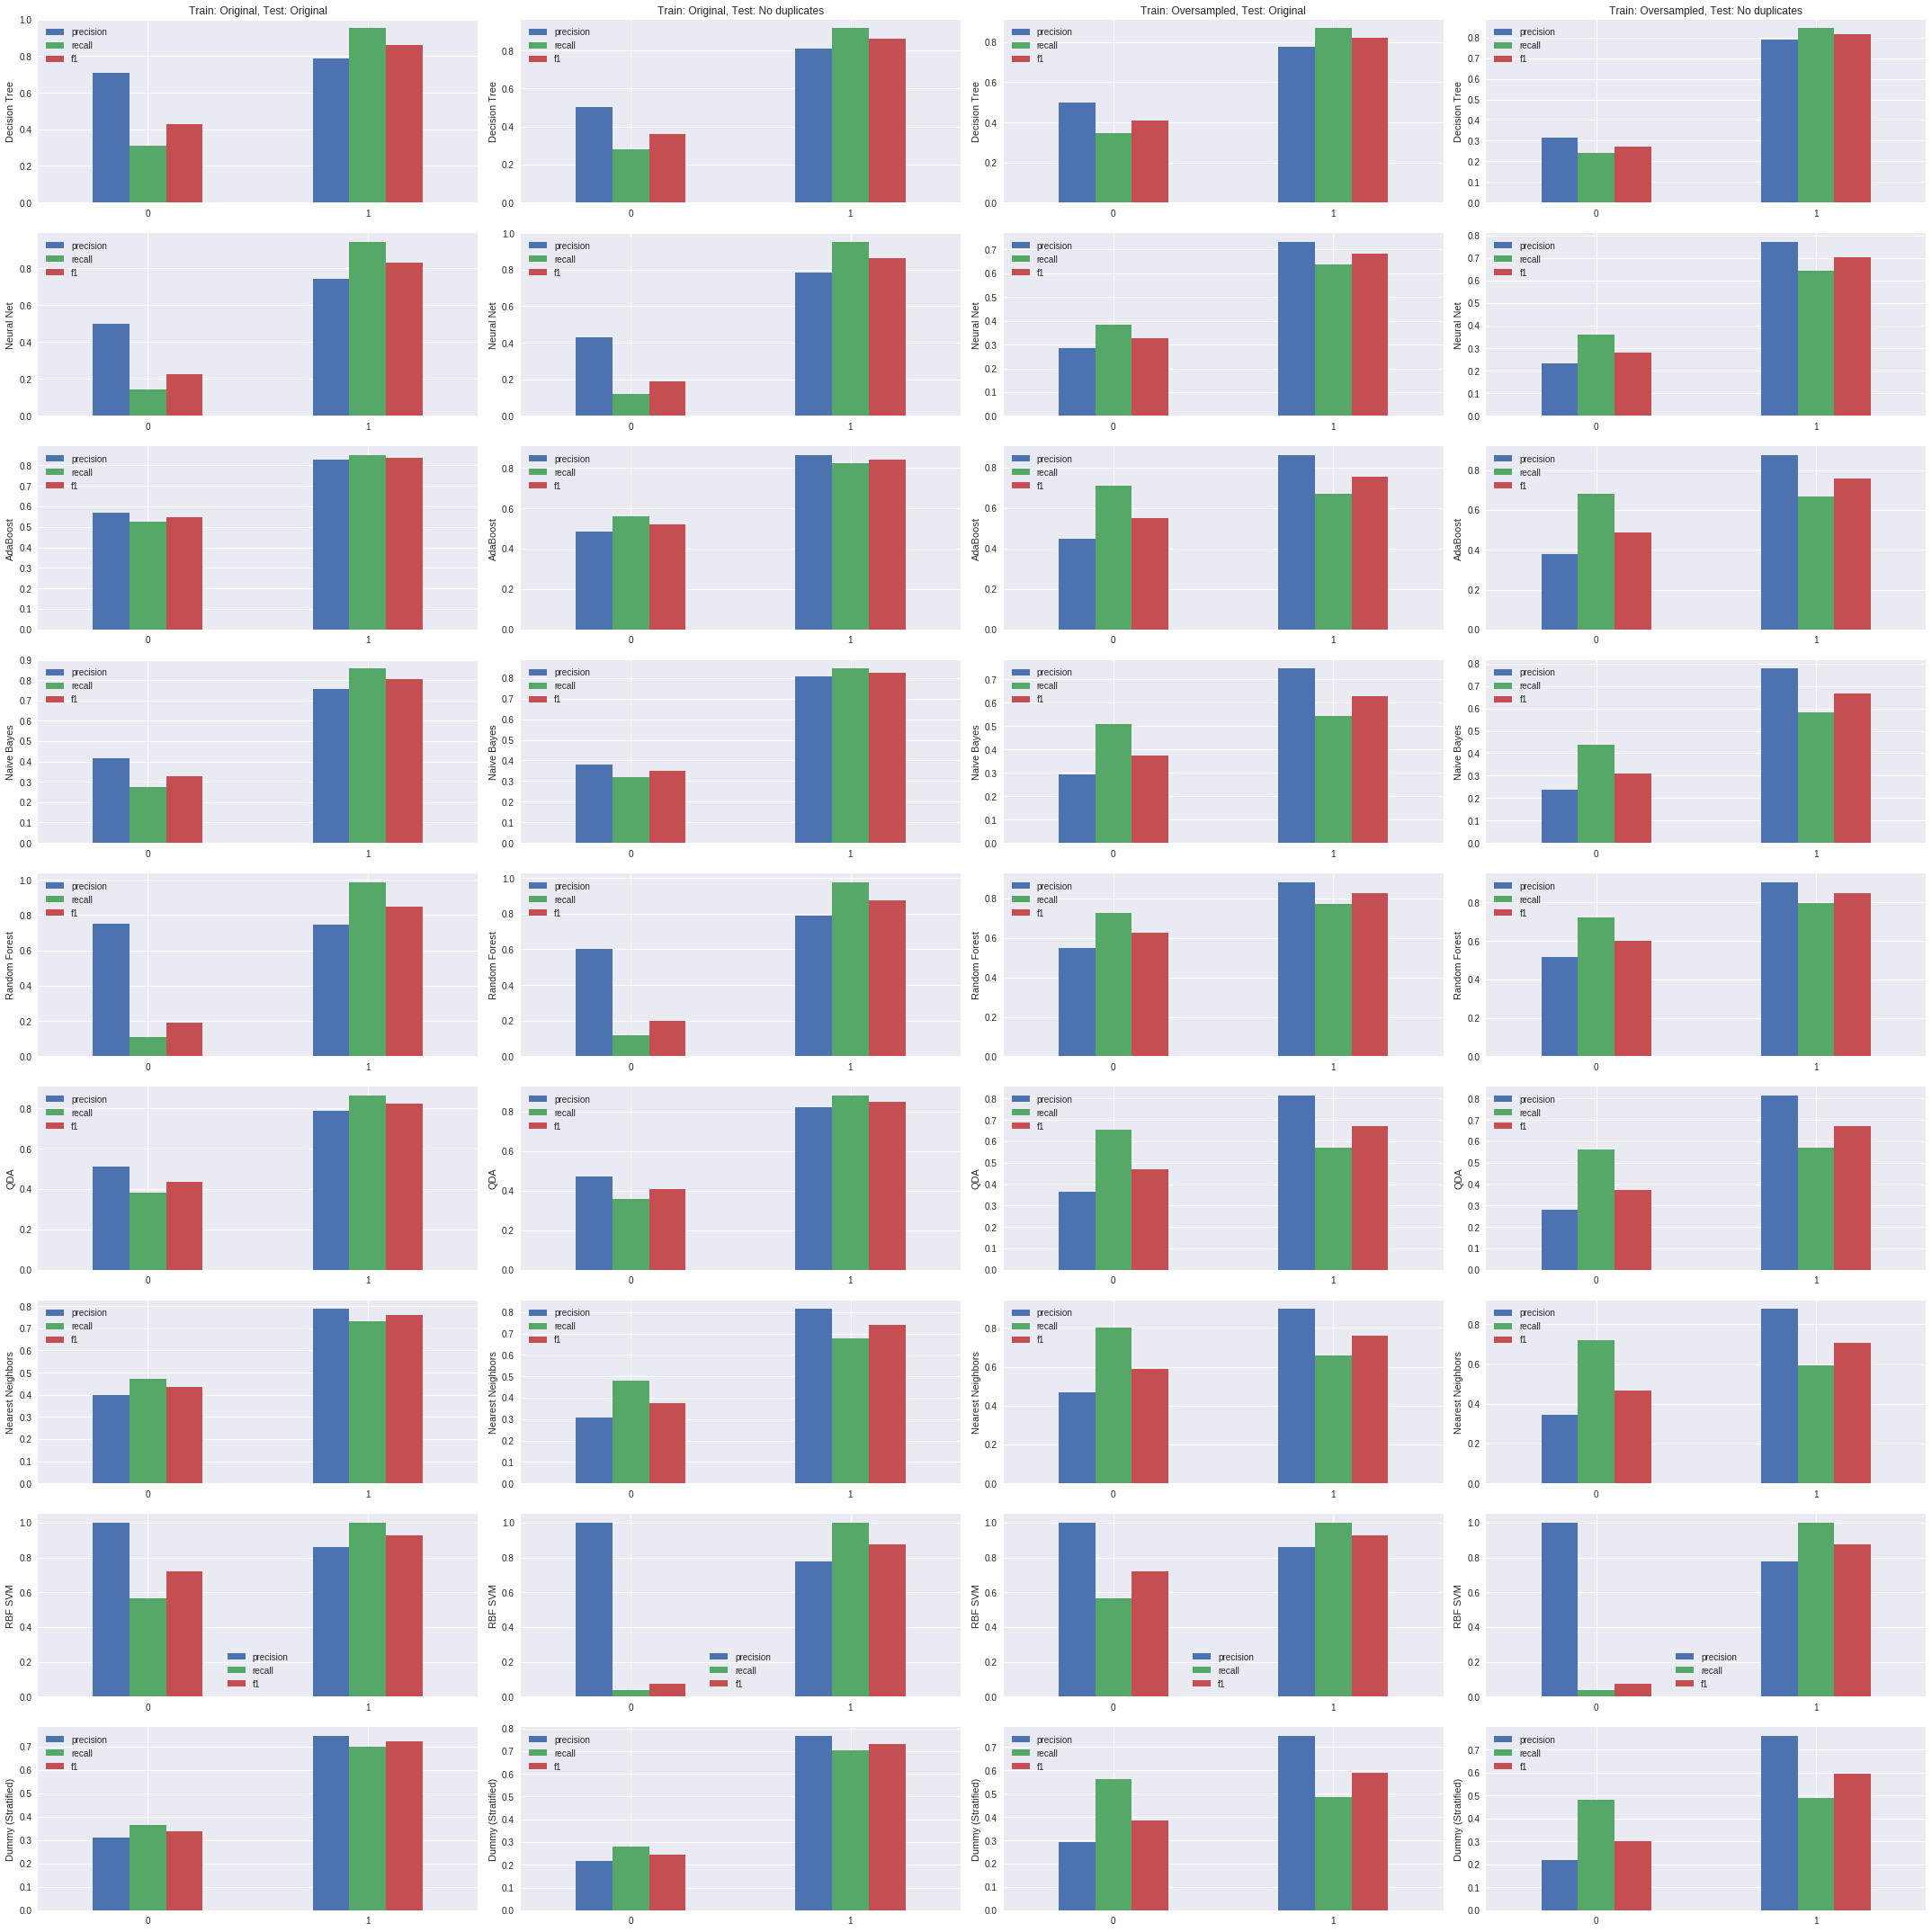

In [35]:
nrows = result_df.clf.unique().shape[0]
ncols = result_df[['train', 'test']].drop_duplicates().shape[0]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))

clfs = result_df.clf.unique()
train_test_pairs = result_df[['train', 'test']].drop_duplicates().values

for i in range(nrows):
    clf = clfs[i]
    clf_results = result_df[(result_df.clf == clf)]
    for j in range(ncols):
        train_test_pair = train_test_pairs[j]
        # print(train_test_pair)
        ax = axes[i, j]
        result = clf_results[(clf_results['train']==train_test_pair[0])&
                            (clf_results['test']==train_test_pair[1])]
        # print(result)
        _ = result[['precision', 'recall', 'f1']].plot(kind='bar', ax=ax, rot=0);
        
        if i == 0:
            _ = ax.set_title('Train: {}, Test: {}'.format(train_test_pair[0], train_test_pair[1]))
        _ = ax.set_ylabel('{}'.format(clf))
        _ = ax.set_xticklabels(result['class'])
        
# plt.savefig('./classificationResult.png')
plt.tight_layout()

In [36]:
# test with original train and no duplicates for test
train_ds = train_ds_list[0]
test_ds = test_ds_list[1]

train_X = train_ds.drop('class_sold', axis=1)
train_y = train_ds['class_sold']

test_X = test_ds.drop('class_sold', axis=1)
test_y = test_ds['class_sold']

for name, clf in zip(names, classifiers):
    if name not in ["Dummy (Stratified)", "Nearest Neighbors", 
         "Decision Tree", "Random Forest", "AdaBoost"]:
        continue
    _ = clf.fit(train_X, train_y);
    y_pred = clf.predict(test_X);
    report = classification_report(y_pred=y_pred, y_true=test_y);
    print('{}'.format(name))
    print(report);
    print();

Dummy (Stratified)
             precision    recall  f1-score   support

          0       0.22      0.28      0.25        25
          1       0.77      0.70      0.73        84

avg / total       0.64      0.61      0.62       109


Nearest Neighbors
             precision    recall  f1-score   support

          0       0.31      0.48      0.38        25
          1       0.81      0.68      0.74        84

avg / total       0.70      0.63      0.66       109


Decision Tree
             precision    recall  f1-score   support

          0       0.50      0.28      0.36        25
          1       0.81      0.92      0.86        84

avg / total       0.74      0.77      0.75       109


Random Forest
             precision    recall  f1-score   support

          0       0.67      0.16      0.26        25
          1       0.80      0.98      0.88        84

avg / total       0.77      0.79      0.74       109


AdaBoost
             precision    recall  f1-score   support

        

In [37]:
# get the original, no duplicates pair
train_ds = train_ds_list[0]
test_ds = test_ds_list[1]

train_X = train_ds.drop('class_sold', axis=1)
train_y = train_ds['class_sold']

test_X = test_ds.drop('class_sold', axis=1)
test_y = test_ds['class_sold']

ds_X = pd.concat([train_X, test_X], axis=0)
ds_y = pd.concat([train_y, test_y], axis=0)

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(ds_X, ds_y)

In [38]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(clf, out_file='tree.dot',
                               feature_names=train_X.columns,
                               class_names=['Deserted', 'Sold'],
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

![tree](./tree.png)

## Clustering

In [39]:
from sklearn import metrics
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import kneighbors_graph
import warnings, time
from itertools import cycle, islice


### Scale all values to [0, 1]

In [40]:
# remove the class_sold
cluster_ds = trace_df.drop('class_sold', axis=1)
min_max_scaler = MinMaxScaler()
cluster_ds_scaled = min_max_scaler.fit_transform(cluster_ds)
# cluster_ds_scaled = StandardScaler().fit_transform(cluster_ds)
cluster_ds_scaled = pd.DataFrame(cluster_ds_scaled)
cluster_ds_scaled.columns = cluster_ds.columns

### KMeans clustering

In [41]:
# test until 20 k
maxK = 20
sse_list = np.zeros(maxK)
# number of different initial centroids
n_init = 20
n_jobs = -1
for i in range(maxK):
    k = i + 1
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=k, n_jobs=n_jobs).fit(cluster_ds_scaled)
    # get the sse from kmeans
    sse_list[i] = kmeans.inertia_

In [42]:
sse_zip = list(zip(*enumerate(sse_list)))
sse_dict = {'k': sse_zip[0],
           'sse': sse_zip[1]}
sse_df = pd.DataFrame(sse_dict)
sse_df.k = sse_df.k.apply(lambda x: x + 1)

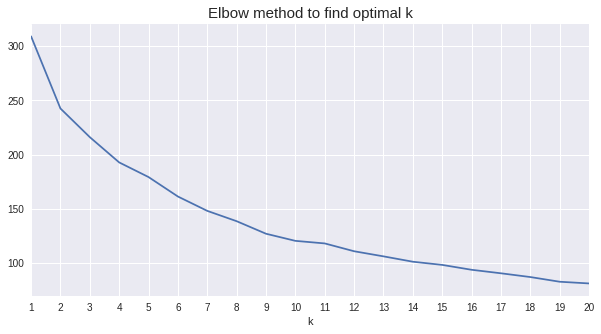

In [43]:
sse_df.set_index(sse_df.k, inplace=True)
ax = sse_df.sse.plot(xticks=sse_df.index, figsize=(10, 5))
_ = ax.set_title('Elbow method to find optimal k', fontsize=15)

In [44]:
op_k = 2
n_init = 20
n_jobs = -1

kmeans = KMeans(n_clusters=op_k, n_init=n_init, n_jobs=n_jobs).fit(cluster_ds_scaled)
# add the assigned classes to result
result = cluster_ds_scaled.copy(deep=True)
result['label'] = kmeans.labels_

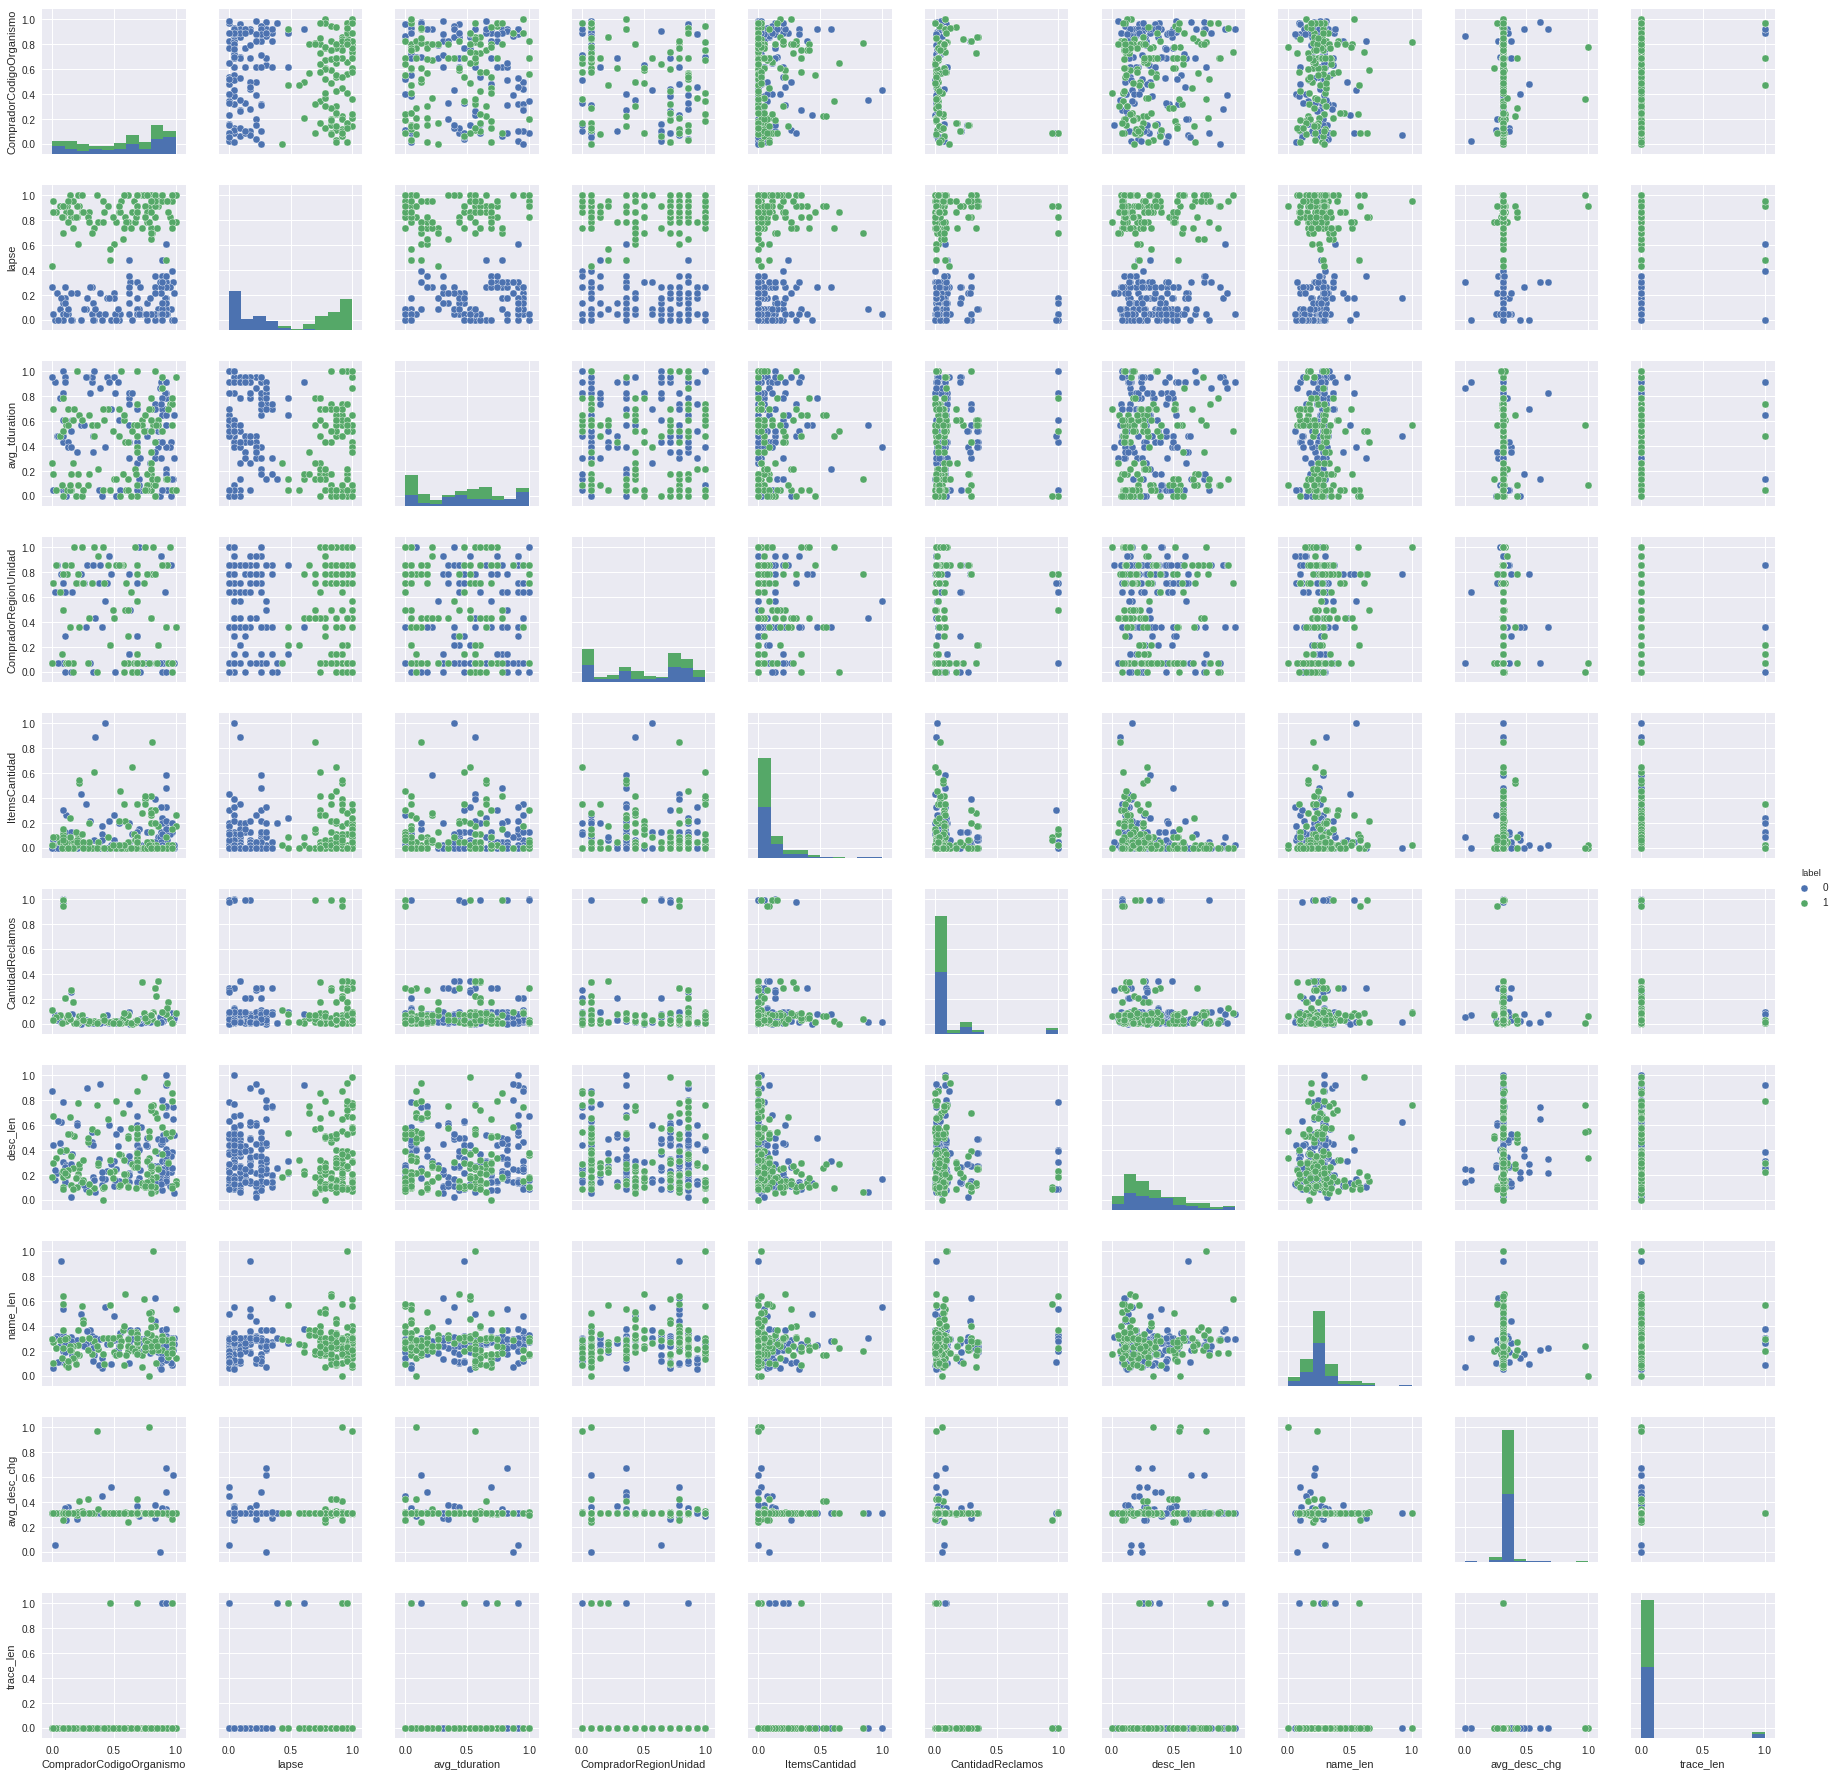

In [45]:
to_plot = [col for col in result.columns if col != 'label']
ax = sns.pairplot(data=result, x_vars=to_plot, y_vars=to_plot, hue='label')

In [46]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Explained variance ratio (first two components): [ 0.2425216  0.1961849]


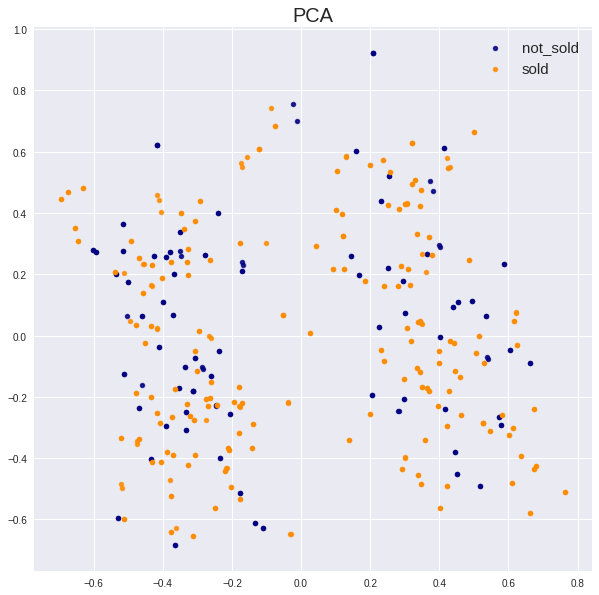

In [47]:
y = trace_df['class_sold']
target_names = ['not_sold', 'sold']
pca = PCA(n_components=2)
X_r = pca.fit(cluster_ds_scaled).transform(cluster_ds_scaled)

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): {}'.format(str(pca.explained_variance_ratio_)))

fig, ax = plt.subplots(figsize=(10, 10))
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_r[y==i, 0], X_r[y==i, 1], color=color, alpha=.8, lw=lw,
               label=target_name, s=12)
ax.legend(loc='best', shadow=False, scatterpoints=1, fontsize=15)
ax.set_title('PCA', fontsize=20);

fig.savefig('./pca.png');

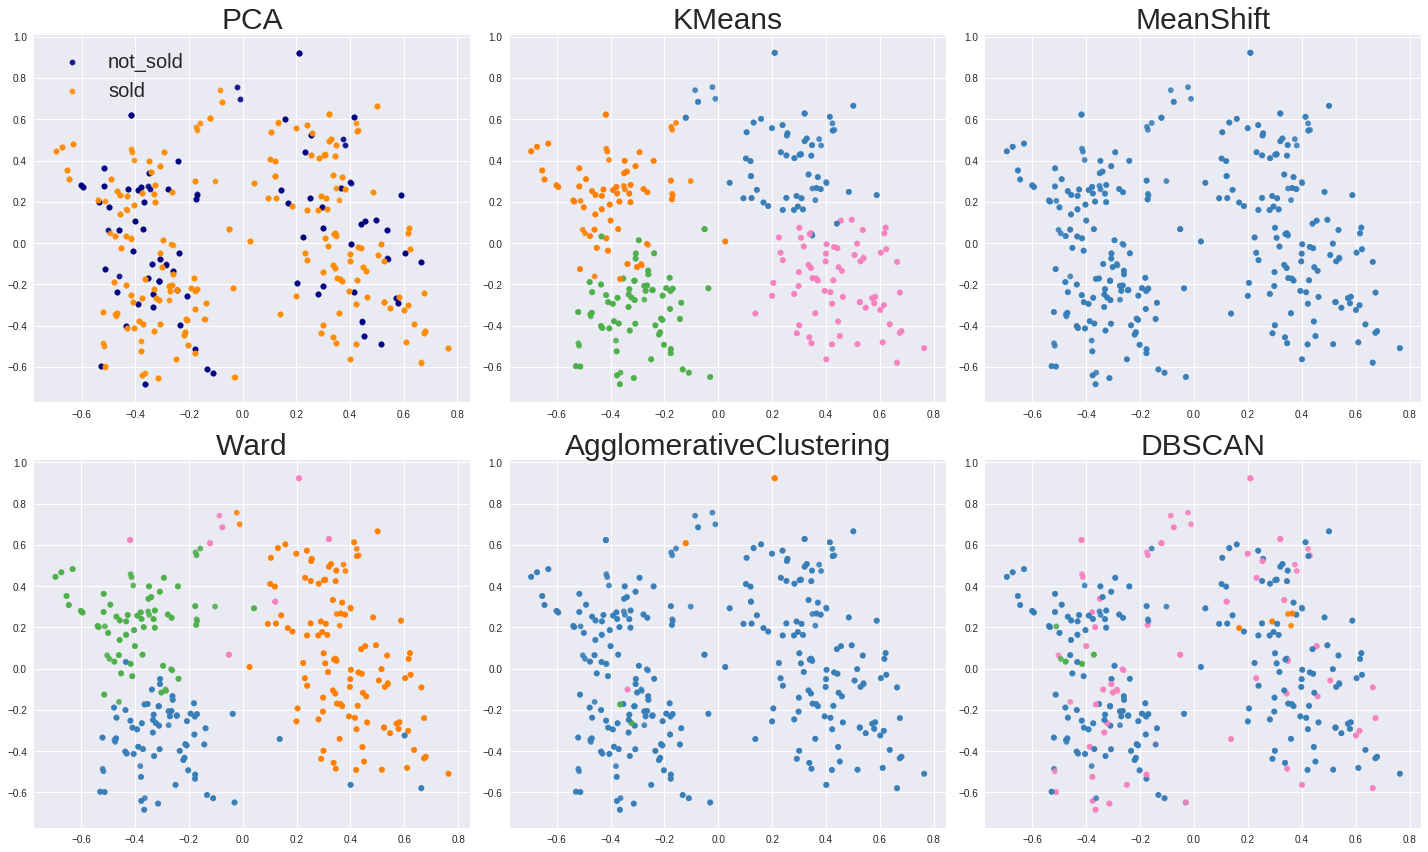

In [51]:
params = {'quantile': .6,
               'eps': .4,
               'damping': .9,
               'preference': -200,
               'n_neighbors': 10, 
               'n_clusters': 4}

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(cluster_ds_scaled.values, quantile=params['quantile'])

# connectivity matrix for structured ward
connectivity = kneighbors_graph(cluster_ds_scaled, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# create the cluster objects
kmeans = cluster.KMeans(n_clusters=params['n_clusters'], n_jobs=-1)
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity
)
dbscan = cluster.DBSCAN(eps=params['eps'])
average_linkage = cluster.AgglomerativeClustering(
    linkage='average', affinity='cityblock', 
    n_clusters=params['n_clusters'], connectivity=connectivity)

clustering_algorithms = (
    ('KMeans', kmeans),
#    ('MiniBatchMeans', two_means),
    ('MeanShift', ms),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan)
)

s = 15
cnt = 1
nrows = 2
ncols = 3
fig, axes = plt.subplots(figsize=(20, 12), nrows=nrows, ncols=ncols)
true_y = trace_df['class_sold']
target_names = ['not_sold', 'sold']
pca = PCA(n_components=2)
X_r = pca.fit(cluster_ds_scaled).transform(cluster_ds_scaled)

colors = ['navy', 'darkorange']
lw = 2
for color, i, target_name in zip(colors, [0, 1], target_names):
    axes[0, 0].scatter(X_r[y==i, 0], X_r[y==i, 1], color=color, alpha=.8, lw=lw,
               label=target_name, s=s)
axes[0, 0].legend(loc='best', shadow=False, scatterpoints=1, fontsize=20)
axes[0, 0].set_title('PCA', fontsize=30);

for name, algorithm in clustering_algorithms:
    t0 = time.time()
    
    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(cluster_ds_scaled)
    
    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(cluster_ds_scaled)
    
    row = cnt // ncols
    col = cnt % ncols
    cnt += 1
    
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
    axes[row, col].scatter(X_r[:, 0], X_r[:, 1], color=colors[y_pred], alpha=.8, lw=lw, s=s)
    axes[row, col].set_title('{}'.format(name), fontsize=30);

plt.tight_layout();

In [49]:
# fig.savefig('./clusterAnalysis.png')

## Analyze clusters created by KMeans using decision trees

In [55]:
params = {'n_clusters': 4}

kmeans = cluster.KMeans(n_clusters=params['n_clusters'], n_jobs=-1)
kmeans.fit(cluster_ds_scaled)
y_pred = kmeans.predict(cluster_ds_scaled)

# join the two together
clf_dataset = cluster_ds_scaled.copy(deep=True)
clf_dataset['y_pred'] = y_pred

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [58]:
clf_dataset.drop('y_pred', axis=1).columns

Index(['CompradorCodigoOrganismo', 'lapse', 'avg_tduration',
       'CompradorRegionUnidad', 'ItemsCantidad', 'CantidadReclamos',
       'desc_len', 'name_len', 'avg_desc_chg', 'trace_len'],
      dtype='object')

In [62]:
# apply decision tree
clf = DecisionTreeClassifier(max_depth=5)
feature_ds = clf_dataset.drop('y_pred', axis=1)
clf = clf.fit(feature_ds, clf_dataset['y_pred'].values)
# export tree
dot_data = tree.export_graphviz(clf, out_file='clusterTree.dot',
                               feature_names=feature_ds.columns,
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

![clusterTree](./clusterTree.png)

Looking at the divide of the lapse, we want to analyze which are the regions that have less lapse and those that have more.

In [82]:
aux = cluster_ds.copy(deep=True)
aux['y_pred'] = y_pred

class_0_2 = aux[(aux['y_pred'].isin([0, 2]))]
class_1_3 = aux[(aux['y_pred'].isin([1, 3]))]

In [83]:
# use label encoder to reverse to get region names
le = le_dict['CompradorRegionUnidad']
class_0_2['region'] = le.inverse_transform(class_0_2.CompradorRegionUnidad)
class_1_3['region'] = le.inverse_transform(class_1_3.CompradorRegionUnidad)

In [86]:
sorted(class_0_2.region.unique())
sorted(class_1_3.region.unique())

['Region Aysen del General Carlos Ibanez del Campo',
 'Region Metropolitana de Santiago',
 'Region de Antofagasta',
 'Region de Arica y Parinacota',
 'Region de Atacama',
 'Region de Coquimbo',
 'Region de Los Rios',
 'Region de Magallanes y de la Antartica',
 'Region de Tarapaca',
 'Region de Valparaiso',
 'Region de la Araucania',
 'Region de los Lagos',
 'Region del Biobio',
 'Region del Libertador General Bernardo O Higgins',
 'Region del Maule']

['Region Aysen del General Carlos Ibanez del Campo',
 'Region Metropolitana de Santiago',
 'Region de Antofagasta',
 'Region de Arica y Parinacota',
 'Region de Atacama',
 'Region de Coquimbo',
 'Region de Los Rios',
 'Region de Magallanes y de la Antartica',
 'Region de Tarapaca',
 'Region de Valparaiso',
 'Region de la Araucania',
 'Region de los Lagos',
 'Region del Biobio',
 'Region del Libertador General Bernardo O Higgins',
 'Region del Maule']

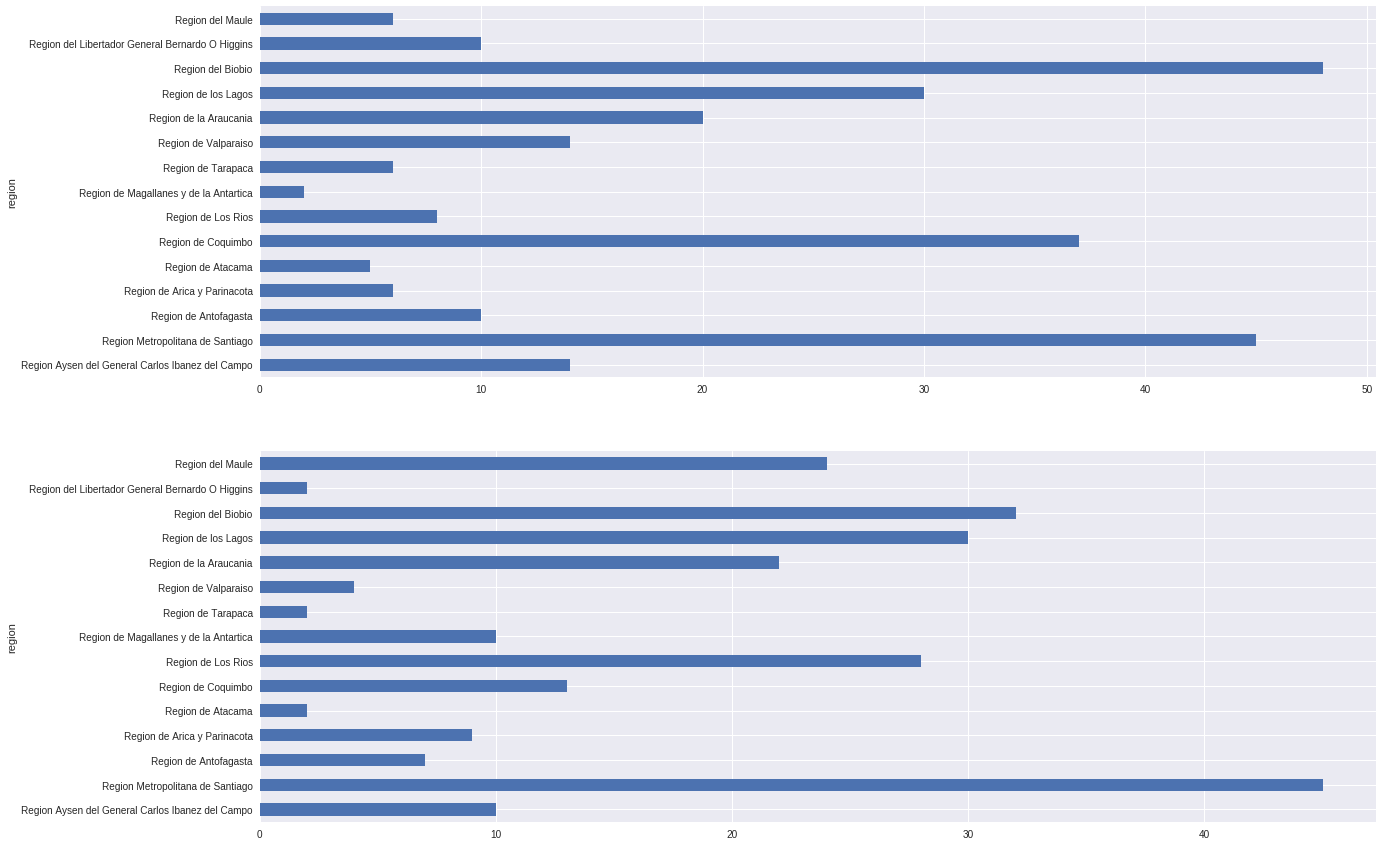

In [84]:
# plot with lapse
fig, axes = plt.subplots(figsize=(20, 15), nrows=2, ncols=1)

class_0_2[['region', 'lapse']].groupby('region').size().plot(kind='barh', ax=axes[0])
class_1_3[['region', 'lapse']].groupby('region').size().plot(kind='barh', ax=axes[1]);